## Install dependencies

In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.5/169.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: pystac
    Found existing installation: pystac 1.6.1
    Uninstalling pystac-1.6.1:
      Successfully uninstalled pystac-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rastervision-core 0.20.3.dev0 requires geopandas==0.12.0, but you have geopandas 0.13.2 which is incompatible.
rastervision-core 0.20.3.dev0 requires imageio==2.22.1, but you have imageio 2.31.1 which is incompatible.
rastervision-core 0.20.3.dev0 requires numpy==1.23.3, but you have numpy 1.25.0 which is incompatible.
rastervision-core 0.20

---

In [49]:
from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get a time-series of Sentinel-2 images from a STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [3]:
import pystac_client
import pystac
import stackstac

https://en.wikipedia.org/wiki/2022_Pakistan_floods

In [4]:
bbox = Box(xmin=67.882, ymin=27.674, xmax=67.929, ymax=27.825)
# bbox_geometry = {'type': 'Polygon',
  # 'coordinates': (((bbox.xmin, bbox.ymin),
  #   (bbox.xmax, bbox.ymin),
  #   (bbox.xmax, bbox.ymax),
  #   (bbox.xmin, bbox.ymax),
  #   (bbox.xmin, bbox.ymin)),)}
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox_geometry

{'type': 'Polygon',
 'coordinates': (((67.88199999999998, 27.67399999999999),
   (67.92899999999999, 27.67399999999999),
   (67.92899999999999, 27.824999999999967),
   (67.88199999999998, 27.825000000000024),
   (67.88199999999998, 27.67399999999999)),)}

In [5]:
%%time

URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2018-01-01",
    query={"eo:cloud_cover": {"lt": 25}},
).item_collection()

len(items)

CPU times: user 211 ms, sys: 16.8 ms, total: 228 ms
Wall time: 1.68 s


48

In [13]:
# items.save_object('42R_2017-01-01--2023-07-01.json')

In [ ]:
# items = pystac.item_collection.ItemCollection.from_file('42R_2017-01-01--2023-07-01.json')
# len(items)

In [6]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-f09f874cebd4e50a7501d4a4ac68a85d' (time: 48,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(48, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2017-01-02...
    id                                       (time) <U24 'S2A_42RUR_20170102_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.1e+06 ... 2.99e+06
    eo:cloud_cover                           (time) float64 22.58 ... 3.273
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(300000.0, 2990220.0, 409800.0...
    crs:         epsg:32642
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3100020.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [7]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [8]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'scl', # B10 (?)
        'swir16', # B11
        'swir22', # B12
    ])

In [31]:
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=0, y=0, band=[3]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-f09f874cebd4e50a7501d4a4ac68a85d' (time: 23,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(23, 13, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2017-01-02...
    id                                       (time) <U24 'S2A_42RUR_20170102_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.1e+06 ... 2.99e+06
    eo:cloud_cover                           (time) float64 22.58 ... 0.2221
    ...                                       ...
    title                                    (band) <U31 'Coastal aerosol (ba...
    gsd                                      (band) object 60 10 10 ... 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(300000.0, 2990220.0, 409800.0...
    crs:         epsg:32642
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3100020.00|\n| 0.0...
    resolution:  10.0

### Create the `RasterSource`

In [9]:
stats_tf = StatsTransformer.from_stats_json('stats.json')

In [32]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    temporal=True
)
raster_source.shape

(23, 10980, 10980, 13)

In [33]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

  0%|          | 0/23 [00:00<?, ?it/s]

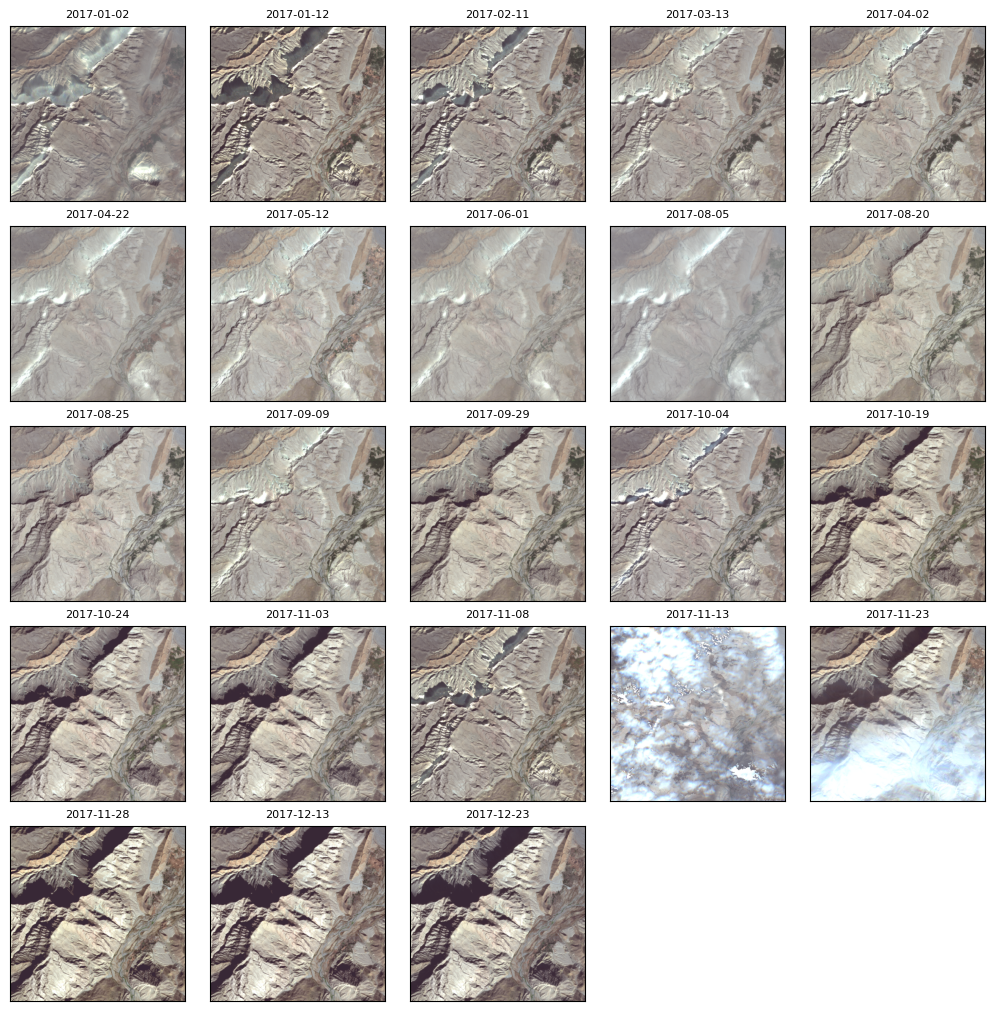

In [37]:
window = Box(0, 0, 500, 500)

plt.close('all')
ncols = 5
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(range(T), t_strs, axs.flat), total=T) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

In [36]:
len(raster_source.extent.get_windows(500, 500))

484

---

## Get model

https://github.com/zhu-xlab/SSL4EO-S12

MoCo	ResNet18	S2-L1C 13 bands

In [38]:
from torch import nn
from torchvision.models import resnet18
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [39]:
sd = torch.load('./B13_rn18_moco_0099_ckpt.pth')
sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}

In [40]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
model.load_state_dict(sd_encoder_q_no_prefix)
model = model.to(device=DEVICE)
model = model.eval()

In [66]:
# resnet_feature_extractor = torch.hub.load(
#     '/home/adeel/pytorch-fpn/',
#     'ResNetFeatureMapsExtractor',
#     model,
#     source='local',
#     trust_repo=True,
# )
# resnet_feature_extractor = resnet_feature_extractor.to(device=DEVICE)
# resnet_feature_extractor = resnet_feature_extractor.eval()

In [ ]:
# with torch.inference_mode():
#     out = resnet_feature_extractor(torch.rand((1, 13, 256, 256)).to(device=DEVICE))
# len(out)

In [41]:
with torch.inference_mode():
    out = model(torch.rand((1, 13, 256, 256)).to(device=DEVICE))
out.shape

torch.Size([1, 512])

---

In [119]:
model_weights_path = 'https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/tutorials-data/temporal/pretrained-resnet18-weights.pth'
model = torch.hub.load(
    'AdeelH/geospatial-time-series:rv-demo',
    'SeriesResNet18',
    source='github',
    trust_repo=False,
)
model.load_state_dict(
    torch.hub.load_state_dict_from_url(model_weights_path))
model = model.to(device=DEVICE)
model = model.eval()

The repository AdeelH_geospatial-time-series does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


The repository is already trusted.


Downloading: "https://github.com/AdeelH/geospatial-time-series/zipball/rv-demo" to /root/.cache/torch/hub/rv-demo.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 25.3MB/s]
Downloading: "https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/tutorials-data/temporal/pretrained-resnet18-weights.pth" to /root/.cache/torch/hub/checkpoints/pretrained-resnet18-weights.pth
100%|██████████████████████████████████████████████████████████████████████████████| 45.8M/45.8M [00:01<00:00, 27.3MB/s]


---

## Run inference

In [51]:
embeddings = {}
for t in range(T):
    print(t_strs[t])
    embeddings_t = []
    raster_source_t = XarraySource(
        data_array.isel(time=t),
        crs_transformer=crs_transformer,
        raster_transformers=[stats_tf],
    )
    ds = SemanticSegmentationSlidingWindowGeoDataset(Scene('', raster_source_t), 500, 500)
    dl = DataLoader(ds, batch_size=32, num_workers=0)
    with torch.inference_mode(), tqdm(dl) as bar:
        for x, _ in bar:
            _x = x.to(device=DEVICE)
            out = model(_x)
            embeddings_t.append(out.cpu().numpy())
    embeddings_t = np.concatenate(embeddings_t)
    embeddings[t_strs[t]] = embeddings_t
    break

2017-01-02


  0%|          | 0/16 [00:00<?, ?it/s]

---

In [60]:
embeddings['2017-01-02'] = dict(embeddings=embeddings['2017-01-02'], windows=ds.windows)

In [62]:
embeddings['2017-01-02']['windows']

[Box(ymin=0, xmin=0, ymax=500, xmax=500),
 Box(ymin=0, xmin=500, ymax=500, xmax=1000),
 Box(ymin=0, xmin=1000, ymax=500, xmax=1500),
 Box(ymin=0, xmin=1500, ymax=500, xmax=2000),
 Box(ymin=0, xmin=2000, ymax=500, xmax=2500),
 Box(ymin=0, xmin=2500, ymax=500, xmax=3000),
 Box(ymin=0, xmin=3000, ymax=500, xmax=3500),
 Box(ymin=0, xmin=3500, ymax=500, xmax=4000),
 Box(ymin=0, xmin=4000, ymax=500, xmax=4500),
 Box(ymin=0, xmin=4500, ymax=500, xmax=5000),
 Box(ymin=0, xmin=5000, ymax=500, xmax=5500),
 Box(ymin=0, xmin=5500, ymax=500, xmax=6000),
 Box(ymin=0, xmin=6000, ymax=500, xmax=6500),
 Box(ymin=0, xmin=6500, ymax=500, xmax=7000),
 Box(ymin=0, xmin=7000, ymax=500, xmax=7500),
 Box(ymin=0, xmin=7500, ymax=500, xmax=8000),
 Box(ymin=0, xmin=8000, ymax=500, xmax=8500),
 Box(ymin=0, xmin=8500, ymax=500, xmax=9000),
 Box(ymin=0, xmin=9000, ymax=500, xmax=9500),
 Box(ymin=0, xmin=9500, ymax=500, xmax=10000),
 Box(ymin=0, xmin=10000, ymax=500, xmax=10500),
 Box(ymin=0, xmin=10500, ymax=500, x